In [1]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe,
                       calc_romad, create_dataset, deep_learning_dataset)

In [2]:
import numpy as np
import pandas as pd
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

%matplotlib inline
pd.options.display.max_rows = 100

In [3]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                  'EURUSD_1h_2003-2020.csv',
#                  'GBPUSD_1h_2003-2020.csv',
#                  'USDJPY_1h_2003-2020.csv',
#                  'NZDUSD_1h_2003-2020.csv',
#                  'AUDUSD_1h_2003-2020.csv',
#                  'USDCAD_1h_2003-2020.csv',
#                  'USDCHF_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-11-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2020.csv


In [4]:
class algo_variables():
    pass

var = algo_variables()
var.window = 100 # number of training bars
var.pca_features = False # False, 10  #must be smaller than window
var.standardize = 'min_max' #'std', 'min_max' False
var.norm_by_vol = False #True
var.data_percentage_diff = 'close_diff' # False, 'close_diff', 'ohlc_diff', 'open_diff'
var.data_percentage_diff_y = True
var.train_split = datetime(2019,1,1) #0.9, datetime(2018,1,1)
var.resample = '1D' # None '1D', '4H', '1W'
var.read_single_file = None #all_files[3] #None
var.loaded_files = loaded_files

var.num_bars = 50 # prediction horizon
var.problem_type = 'binary' #'regression' 'binary' 'category'
if var.problem_type == 'category':
    var.std_thresh = 0.5 # to determine a positive, negative or flat trade
var.dataset_type = 'stock' #'wave', 'random', 'stock', 'monte_carlo'
var.close_only = False
if var.close_only:
    var.cols = ['Close'] if var.dataset_type in ['stock','monte_carlo'] else ['univariate']
else:
    var.cols = ['Open', 'High', 'Low', 'Close'] if var.dataset_type == 'stock' else ['univariate']
var.multi_y = False

###
var.input_len = var.pca_features if var.pca_features else var.window
###

## target/stop binary outcomes (1 R/R) ##
var.target_stop = False 
if var.target_stop:
    var.num_bars = 1 # must be equal to 1!
    var.problem_type = 'binary'
    var.dataset_type = 'stock'
    var.close_only = False
    var.cols = ['Open', 'High', 'Low', 'Close']
    var.bar_horizon = 10000 # how long to wait for stop or target hit, otherwise assign current profit
    var.bar_size_ma = 100 # how long is moving average for bar size (used to calc stop and target)
    var.stop_target_size = 4 # size of stop and target relative to averge bar size


var.embeddings = False
var.embedding_type = None #None 'light'
if var.embeddings:
    var.standardize = False 
    var.pca_features = False
    var.vector_size = 200 # 200, 4
    if var.embedding_type == 'light':
        var.vector_size = 1
    
generator = False
if generator: 
    ## save all stocks to csv and tfrecords, then load tfrecords as dataset
    var.train_validation = 0.8 #False # Uses traning data to create test set (for validation)
    var.batch_size = 500
    base_path = f'C:/Users/Jameshuckle/Documents/Algo_Trading/data'
    save_numpy_to_csv_all_files(base_path, var)
    train_dataset = create_tfrecord_dataset(f'{base_path}/all_data_train', var)
    test_dataset = create_tfrecord_dataset(f'{base_path}/all_data_test', var)
else:
    ### load single stock into numpy
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)
    train_dataset, test_dataset = [], []

In [5]:
train_data_raw.shape, x.shape

((4827, 4), (4678, 100, 4))

In [6]:
image_size = 10
gasf = GramianAngularField(image_size=image_size, method='summation') #'summation' , 'difference'
gasf_train_list = []
for idx in range(len(var.cols)):
    x_gasf = gasf.fit_transform(x[:,:,idx])
    if len(var.cols) > 1:
        x_gasf = np.expand_dims(x_gasf, axis=3)
    gasf_train_list.append(x_gasf)
    
gasf_test_list = []
for idx in range(len(var.cols)):
    x_test_gasf = gasf.fit_transform(x_test[:,:,idx])
    if len(var.cols) > 1:
        x_test_gasf = np.expand_dims(x_test_gasf, axis=3)
    gasf_test_list.append(x_test_gasf)

C:\Users\Jameshuckle\AppData\Roaming\Python\Python37\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
x = np.concatenate(gasf_train_list, axis=3)
x_test = np.concatenate(gasf_test_list, axis=3)

In [8]:
x.shape

(4678, 10, 10, 4)

In [9]:
x_test.shape

(418, 10, 10, 4)

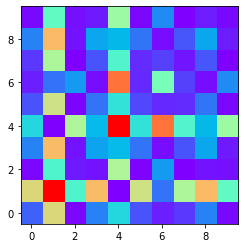

In [10]:
if len(var.cols) == 1:
    plt.imshow(x[0], cmap='rainbow', origin='lower')
else:
    plt.imshow(x[0,:,:,0], cmap='rainbow', origin='lower')

In [11]:
if len(var.cols) == 1:
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=20, kernel_size=2,
                               input_shape=[image_size, image_size]),
        tf.keras.layers.Dense(units=100),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10, kernel_size=2,
                               input_shape=[image_size, image_size, len(var.cols)]),
#         tf.keras.layers.Conv2D(filters=20, kernel_size=3),
#         tf.keras.layers.Conv2D(filters=40, kernel_size=3),
        tf.keras.layers.Dense(units=10),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
epochs = 100
history = model.fit(x, y, validation_data=(x_test, y_test), batch_size=1000, epochs=epochs, verbose=2)
gc.collect()

Epoch 1/100
5/5 - 0s - loss: 0.7167 - accuracy: 0.5115 - val_loss: 0.6466 - val_accuracy: 0.6244
Epoch 2/100
5/5 - 0s - loss: 0.6984 - accuracy: 0.5312 - val_loss: 0.6548 - val_accuracy: 0.6100
Epoch 3/100
5/5 - 0s - loss: 0.6868 - accuracy: 0.5552 - val_loss: 0.6654 - val_accuracy: 0.5981
Epoch 4/100
5/5 - 0s - loss: 0.6770 - accuracy: 0.5727 - val_loss: 0.6734 - val_accuracy: 0.5909
Epoch 5/100
5/5 - 0s - loss: 0.6700 - accuracy: 0.5829 - val_loss: 0.6824 - val_accuracy: 0.5909
Epoch 6/100
5/5 - 0s - loss: 0.6644 - accuracy: 0.5975 - val_loss: 0.6918 - val_accuracy: 0.5766
Epoch 7/100
5/5 - 0s - loss: 0.6590 - accuracy: 0.6099 - val_loss: 0.6974 - val_accuracy: 0.5766
Epoch 8/100
5/5 - 0s - loss: 0.6542 - accuracy: 0.6154 - val_loss: 0.7032 - val_accuracy: 0.5670
Epoch 9/100
5/5 - 0s - loss: 0.6505 - accuracy: 0.6231 - val_loss: 0.7102 - val_accuracy: 0.5646
Epoch 10/100
5/5 - 0s - loss: 0.6464 - accuracy: 0.6280 - val_loss: 0.7149 - val_accuracy: 0.5766
Epoch 11/100
5/5 - 0s - loss:

Epoch 85/100
5/5 - 0s - loss: 0.5998 - accuracy: 0.6759 - val_loss: 0.8050 - val_accuracy: 0.5096
Epoch 86/100
5/5 - 0s - loss: 0.6001 - accuracy: 0.6776 - val_loss: 0.8051 - val_accuracy: 0.5167
Epoch 87/100
5/5 - 0s - loss: 0.5998 - accuracy: 0.6751 - val_loss: 0.8039 - val_accuracy: 0.5335
Epoch 88/100
5/5 - 0s - loss: 0.5998 - accuracy: 0.6761 - val_loss: 0.8073 - val_accuracy: 0.5096
Epoch 89/100
5/5 - 0s - loss: 0.5997 - accuracy: 0.6749 - val_loss: 0.8073 - val_accuracy: 0.5144
Epoch 90/100
5/5 - 0s - loss: 0.5995 - accuracy: 0.6772 - val_loss: 0.8060 - val_accuracy: 0.5191
Epoch 91/100
5/5 - 0s - loss: 0.5998 - accuracy: 0.6766 - val_loss: 0.8051 - val_accuracy: 0.5215
Epoch 92/100
5/5 - 0s - loss: 0.5993 - accuracy: 0.6757 - val_loss: 0.8020 - val_accuracy: 0.5287
Epoch 93/100
5/5 - 0s - loss: 0.5991 - accuracy: 0.6761 - val_loss: 0.8051 - val_accuracy: 0.5215
Epoch 94/100
5/5 - 0s - loss: 0.5992 - accuracy: 0.6764 - val_loss: 0.8069 - val_accuracy: 0.5215
Epoch 95/100
5/5 - 0

12073

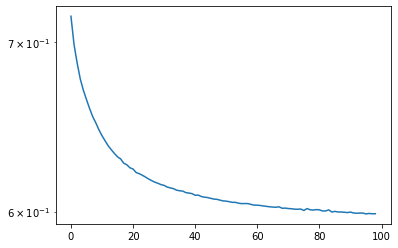

In [14]:
#history.history = hist_info
start_epoch = 0
end_epoch = -1

plt.plot(history.history['loss'][start_epoch:end_epoch])
plt.yscale('log')

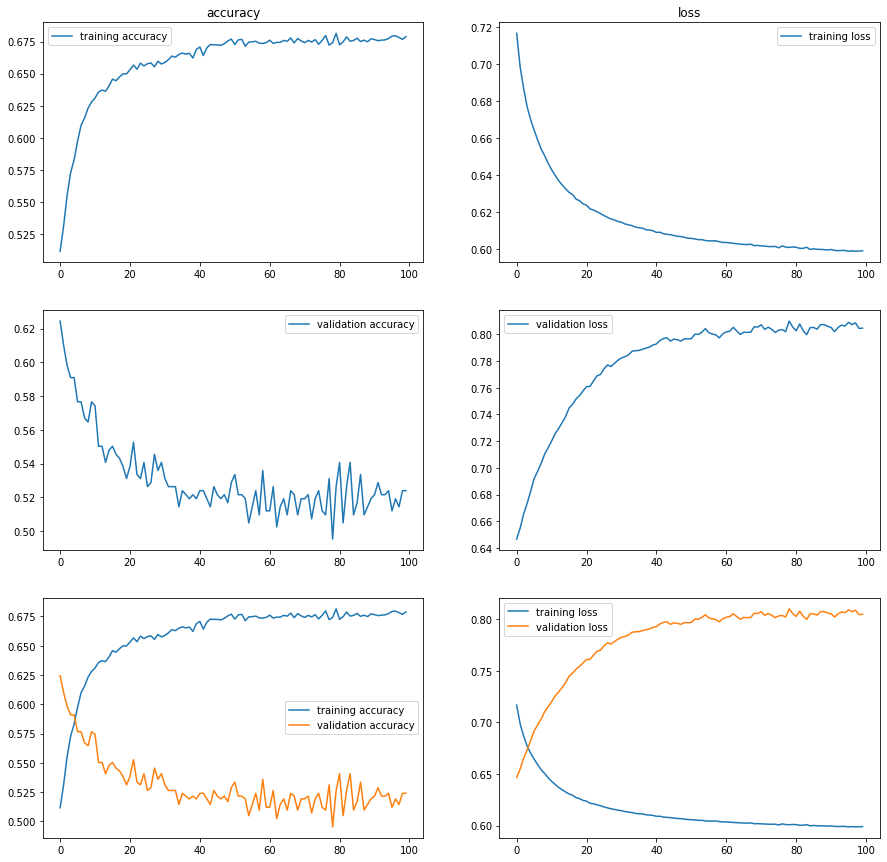

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

metric = 'accuracy'
epoch_show_from = int(epochs * 0)
# metric
ax[0][0].plot(history.history[metric][epoch_show_from:])
ax[0][0].legend([f'training {metric}'])
ax[0][0].set_title(metric)
# loss
ax[0][1].plot(history.history['loss'][epoch_show_from:])
ax[0][1].legend([f'training loss'])
ax[0][1].set_title('loss')

# metric
ax[1][0].plot(history.history[f'val_{metric}'][epoch_show_from:])
ax[1][0].legend([f'validation {metric}'])
ax[2][0].plot(history.history[metric][epoch_show_from:])
ax[2][0].plot(history.history[f'val_{metric}'][epoch_show_from:])
ax[2][0].legend([f'training {metric}',f'validation {metric}'])

# loss
ax[1][1].plot(history.history[f'val_loss'][epoch_show_from:])
ax[1][1].legend([f'validation loss'])
ax[2][1].plot(history.history['loss'][epoch_show_from:])
ax[2][1].plot(history.history[f'val_loss'][epoch_show_from:])
ax[2][1].legend([f'training loss',f'validation loss'])

In [16]:
def create_review_data_set(review_set):
    if review_set == 'train':
        review_x_data = x 
        review_y_data = y
        review_y_pct_diff = y_pct_diff
    elif review_set == 'test':
        review_x_data = x_test
        review_y_data = y_test
        review_y_pct_diff = y_test_pct_diff
    elif review_set == 'all':
        review_x_data = np.concatenate([x, x_test],axis=0)
        review_y_data = np.concatenate([y, y_test],axis=0)
        review_y_pct_diff = np.concatenate([y_pct_diff, y_test_pct_diff],axis=0)
    return review_x_data, review_y_data, review_y_pct_diff

def format_predictions_tanh(review_x_data):
    raw_predictions = model.predict(review_x_data)
    predictions_tanh = np.where(raw_predictions.flatten() < 0.5, -1, 1) 
    return raw_predictions, predictions_tanh

def cut_off_start_review_data_for_prediction():
    # cut off start of raw data until first prediction candle
    if review_set == 'train':
        review_data_raw = train_data_raw[var.window + var.num_bars -1:]
    elif review_set == 'test':
        review_data_raw = test_data_raw[var.window + var.num_bars -1:]
    elif review_set == 'all':
        review_data_raw = np.concatenate([train_data_raw[var.window + var.num_bars -1:], test_data_raw[var.window + var.num_bars -1:]],axis=0)
    
    if len(var.cols) != 1:
        review_data_raw = review_data_raw[:,-1]   
    
    return review_data_raw

def see_predictions(review_set): 
    review_x_data, review_y_data, review_y_pct_diff = create_review_data_set(review_set)
    raw_predictions, predictions_tanh = format_predictions_tanh(review_x_data)
    review_data_raw = cut_off_start_review_data_for_prediction()
    return review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh

pip_fees = 0
review_set = 'test' #'test' 'train' 'all'

(review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
predictions_tanh) = see_predictions(review_set)

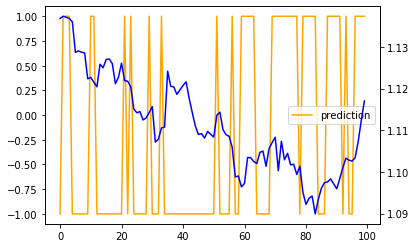

-1 to 1 range: 2


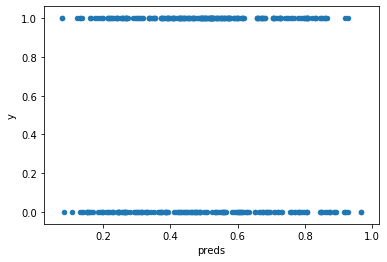

In [17]:
def plot_preds(bars_to_plot):
    fig, ax1 = plt.subplots()
    ax1.plot(predictions_tanh[:bars_to_plot], c='orange')
    ax1.legend(['prediction'])
    ax2 = ax1.twinx()
    ax2.plot(review_data_raw[:bars_to_plot], c='blue')
    #ax2.plot(review_ data_raw[input_len + num_bars: input_len + var.num_bars + bars_to_plot], c='blue')
    plt.show()
    smallest, biggest = predictions_tanh.min(), predictions_tanh.max()
    print(smallest,'to', biggest, 'range:', biggest - smallest )

bars_to_plot = 100
plot_preds(bars_to_plot)

preds = model.predict(x_test)
my_stuff = pd.DataFrame(pd.Series(preds.flatten(), name='preds'))
my_stuff['y'] = y_test
my_stuff.plot.scatter('preds','y')

avg_profit (0 pip fees) 0.0011589677816450982
best possible profit (0 pip fees) 0.018727690830183254


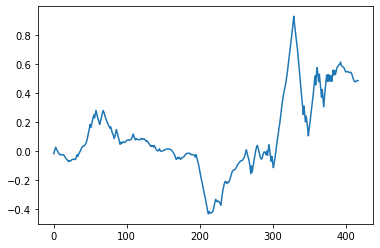

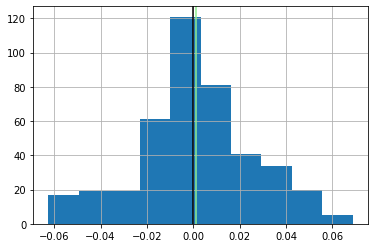

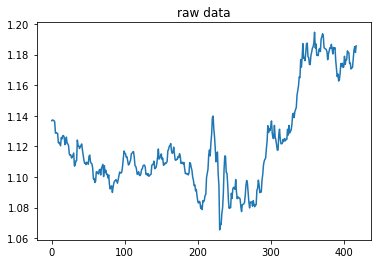

In [18]:
def calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=1):
    returns = pd.DataFrame(pd.Series(review_data_raw, name='test_data_raw'))
    returns['y_pct_diff'] = review_y_pct_diff
    returns['predictions_tanh'] = pd.Series(predictions_tanh.flatten())
    returns['raw_predictions'] = pd.Series(raw_predictions.flatten())
        
    longs = returns.query('predictions_tanh > 0')
    flat = returns.query('predictions_tanh == 0')
    shorts = returns.query('predictions_tanh < 0')
    returns.loc[longs.index, 'profit'] = returns.loc[longs.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns.loc[flat.index, 'profit'] = 0
    returns.loc[shorts.index, 'profit'] = -returns.loc[shorts.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns['returns'] = returns['profit'].cumsum()
    avg_profit = returns['profit'].mean()
    print(f'avg_profit ({pip_fees} pip fees)',avg_profit)
    print(f'best possible profit ({pip_fees} pip fees)',returns['y_pct_diff'].abs().mean())
        
    return avg_profit, returns

def plot_returns():
    returns['returns'].plot()
    plt.show()
    ##
    ax = returns['profit'].hist()
    ax.axvline(0, c='k')
    ax.axvline(avg_profit, c='lightgreen')
    plt.show()
    
review_data_raw = review_data_raw.flatten()
avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=pip_fees)
plot_returns()

plt.plot(review_data_raw)
plt.title('raw data')
plt.show()

### Example

In [19]:
# Parameters
X, _, _, _ = load_gunpoint(return_X_y=True)
# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=10, method='summation')
X_gasf = gasf.fit_transform(X)
gadf = GramianAngularField(image_size=10, method='difference')
X_gadf = gadf.fit_transform(X)

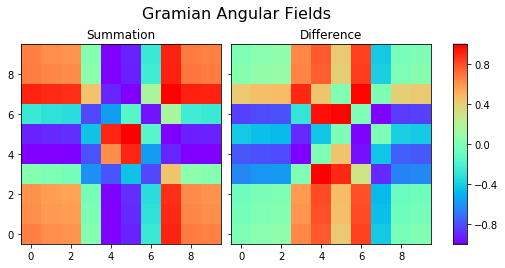

In [20]:
# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[1], X_gadf[1]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()